# Demonstration for the automatic PKIKP onset picker

Load code.

In [1]:
from Picker import *

## Onset Picking 

Summary of the trained CNN model.

In [2]:
model = load_model("TrainedModel.keras")
model.summary()

Model: "PKIKP_Onset_Picker_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 800, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 800, 32)           256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 400, 32)           0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 400, 32)           128       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 400, 64)           10304     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 200, 64) 

Load a PKP waveform example. Here, the waveform has 150-s length. The predicted PKIKP onset by ak135 model (Kennett et al., 1995) is located at the 60th second. Hand-picked PKIKP absolute travel time has been attached in its information.

In [3]:
tr = read("Examples/PKP_NE22.YP.BHZ.SAC")
PKIKP_travel_time = tr[0].stats.sac.t2
waveform_start = tr[0].stats.sac.b
onset = PKIKP_travel_time - waveform_start
prediction = 60 

print("Wavefrom shape:",np.shape(tr))
print("PKIKP onset: ak135 prediction: %.2f s; Hand picking: %.2f s"%(prediction,onset))

Wavefrom shape: (1, 6001)
PKIKP onset: ak135 prediction: 60.00 s; Hand picking: 56.90 s


Pre-process the waveform. A default 50-s length waveform segment around the ak135 prediction is cut as the input of the automatic picker. 

In [4]:
sampling_rate = 40
len_input = 50
freq_filter = [0.5,2]
tr_cut = pre_process(tr, sampling_rate, len_input, freq_filter[0], freq_filter[1])

Pick the PKIKP onset on the processed waveform by calling the Picker function. A 20-s length window is shifting along the input waveform, and the network model returns an instantaneous pick for each step. The pick with the highest quality is chosen as the optimal one.

In [5]:
auto_pick, quality = picker(tr_cut,model, sampling_rate, return_optimal = True)

print("Auto picked PKIKP onset: %.2f s picking quality: %.2f"%(auto_pick[0], quality[0]))
onset_in_window = onset - prediction + len_input / 2
print("Manual pick on the waveform: %.2f s"%onset_in_window)

Auto picked PKIKP onset: 21.66 s picking quality: 0.59
Manual pick on the waveform: 21.90 s


We can simply execute the Picker.py file to do the job above.

In [6]:
!python Picker.py --data_list Examples/List.txt --save_pick Examples/Picks.txt --save_plot Examples

Examples/PKP_320.Z8.BHZ.SAC 
 Auto picked PKIKP onset: 24.66 s picking quality: 0.54
---------------
Examples/PKP_DLV.RM.BHZ.SAC 
 Auto picked PKIKP onset: 26.79 s picking quality: 0.51
---------------
Examples/PKP_NE22.YP.BHZ.SAC 
 Auto picked PKIKP onset: 21.66 s picking quality: 0.59
---------------


## Result plotting

We can acquire all picks with quality and get a quality plot.

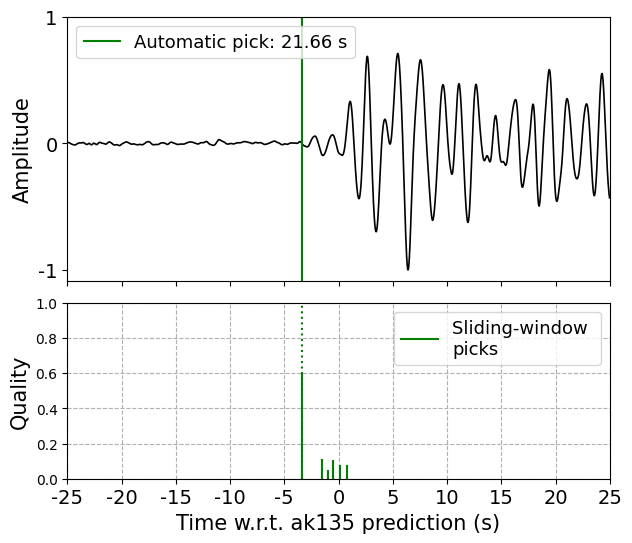

In [7]:
auto_pick_plot(tr_cut, model, "Examples/PKP_NE22.YP.BHZ.SAC.jpg")

An animation displaying the dynamic picking process is saved.

In [8]:
def picking_animation(tr, model, len_input = 50, sampling_rate = 40, t_shift = 0.1, save_name = "Animation.mp4"):  
    from matplotlib.animation import FuncAnimation,FFMpegWriter
    
    len_window = 20
    
    ## Get instantaneous picks
    tt, ts = sliding_window_picking(tr[0], model, only_valid = False)
    ts = [ts[j] + tt[j] for j in range(len(ts))]
    picks,dbscan_labels,counts = cluster_preds(np.array(ts))

    ## plot
    fig,ax = plt.subplots(2,figsize = (10,8),sharex = True)
    ax[0].set_ylim(-1.05,1.05)
    ax[0].plot(np.arange(0,len_input,1/sampling_rate),tr[0])
#     ax[0].axvline(onset_in_window, c= "r",lw = 2, ls = "--", label = "Human picked arrival")
    ln1, = ax[0].plot([],[], c= "g",lw = 2, label = "Instantaneous CNN pick")
    ln2, = ax[0].plot([], [], 'tab:grey',label = "Sliding window")
    ln3, = ax[0].plot([], [], 'tab:grey')
    ax[0].legend(loc = "upper right")
    ax[1].set_ylim(0,1)
    ax[1].set_xlabel("Time (s)",fontsize = 15)
    ax[1].set_ylabel("Quality",fontsize = 15)
    ax[1].set_xticks(np.arange(0,51,5))
    ln4, = ax[1].plot([],[],"go",ms=1.5)
    collection = ax[0].fill_between([0,len_window],-1.05,1.05,facecolor = "lightgrey",alpha = 0.5)
    xdata3,ydata3 = [],[]
    def update(frame):
        xdata = ts[frame]
        ydata = np.linspace(-1.05,1.05,100)
        xdata2 = tt[frame]
        xdata3.append(picks[dbscan_labels[frame]])
        dbscan_label_f = len([d for d in dbscan_labels[0:frame+1] if d == dbscan_labels[frame]])

        if picks[dbscan_labels[frame]] != 0 and dbscan_labels[frame] != -1:
            try:
                len_ydata3 = dbscan_label_f/(len_window/t_shift)
            except ZeroDivisionError:
                len_ydata3 = 0
        else:
            len_ydata3 = 0
        ydata3.append(len_ydata3)

        dummy = ax[0].fill_between([xdata2,xdata2+len_window], -1.05, 1.05, alpha=0)
        dp = dummy.get_paths()[0]
        dummy.remove()
        #update the vertices of the PolyCollection
        collection.set_paths([dp.vertices])

        ln1.set_data(xdata,ydata)
        ln2.set_data([xdata2],ydata)
        ln3.set_data([xdata2+len_window],ydata)
        ln4.set_data(xdata3,ydata3)

        return ln1,ln2,ln3,ln4

    ani = FuncAnimation(fig, func = update, frames=len(ts), blit=True, repeat = False)
    writer = FFMpegWriter(fps = 15)
    ani.save(save_name,writer = writer,dpi = 300)

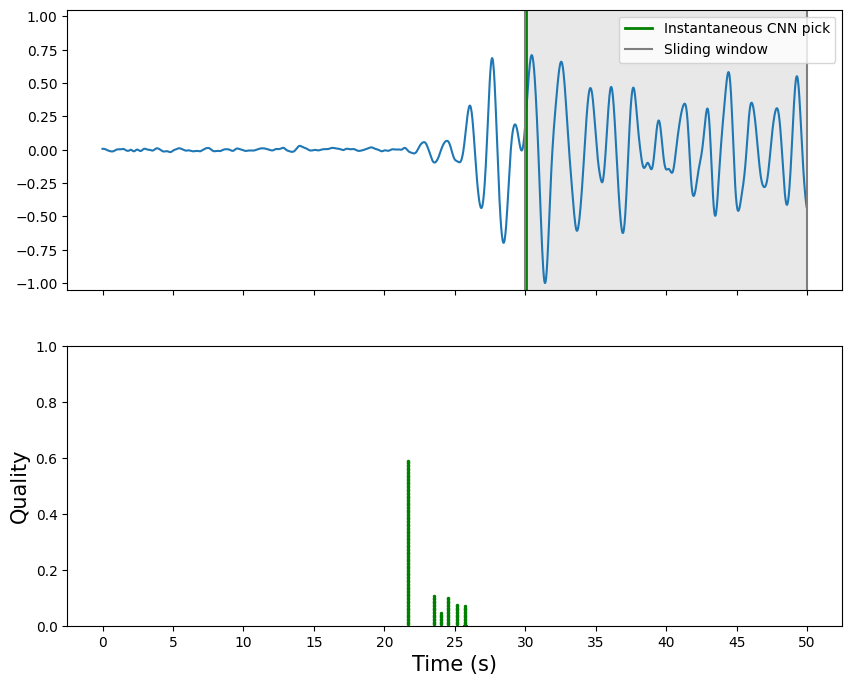

In [9]:
picking_animation(tr_cut, model, save_name = "Examples/Animation.mp4")